In [1]:
import numpy as np
import struct
from netCDF4 import Dataset  
from matplotlib import pyplot as plt
import seaborn as sbs

#rootgrp = Dataset("/home/shjewell/PycharmProjects/basic_geo_dashboard/data/master_20010101-20051231.nc")
rootgrp = Dataset("/home/shjewell/PycharmProjects/basic_geo_dashboard/data/master-20010101-20051231.nc")
lats = rootgrp.variables['lat'][:]
lons = rootgrp.variables['lon'][:]
#t_max = rootgrp.variables['tasmaxAdjust'][:]

seattle_coords = {'lat': 47.6, 'lon':-122.3}
slc_coords = {'lat': 40.8, 'lon': -111.9}

In [2]:
seattle_idx = {'lat': (np.abs(lats - seattle_coords['lat'])).argmin(), 'lon': (np.abs(lons - seattle_coords['lon'])).argmin()}
slc_idx = {'lat': (np.abs(lats - slc_coords['lat'])).argmin(), 'lon': (np.abs(lons - slc_coords['lon'])).argmin()}

In [3]:
seattle_tmax = rootgrp.variables['tasmaxAdjust'][:][:, seattle_idx['lat'], seattle_idx['lon']]
slc_tmax = rootgrp.variables['tasmaxAdjust'][:][:, slc_idx['lat'], slc_idx['lon']]
seattle_daily_mean = rootgrp.variables['tasAdjust'][:][:, seattle_idx['lat'], seattle_idx['lon']]
slc_daily_mean = rootgrp.variables['tasAdjust'][:][:, slc_idx['lat'], slc_idx['lon']]

seattle_set_mean = np.nanmean(seattle_daily_mean)
slc_set_mean = np.nanmean(slc_daily_mean)

print(seattle_set_mean, slc_set_mean)

284.32114 281.97748


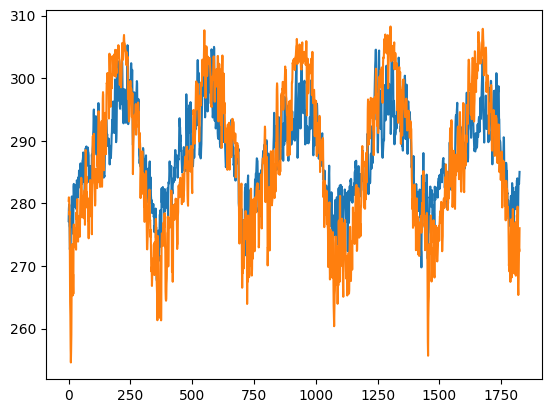

In [4]:
plt.plot(seattle_tmax)
plt.plot(slc_tmax)
plt.show()

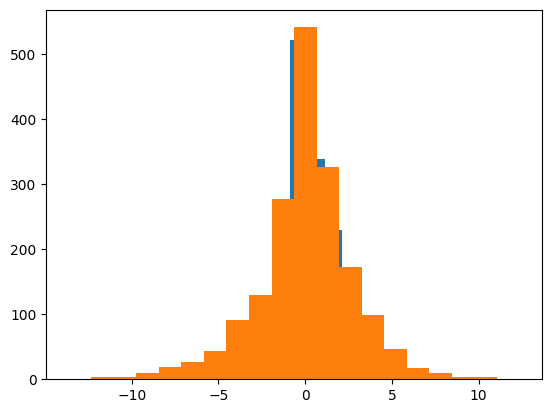

In [5]:
seattle_max_diff = np.diff(seattle_tmax - seattle_set_mean)
slc_max_diff = np.diff(slc_tmax - slc_set_mean)

plt.hist(seattle_max_diff, bins=20)
plt.hist(slc_max_diff, bins=20)
plt.show()

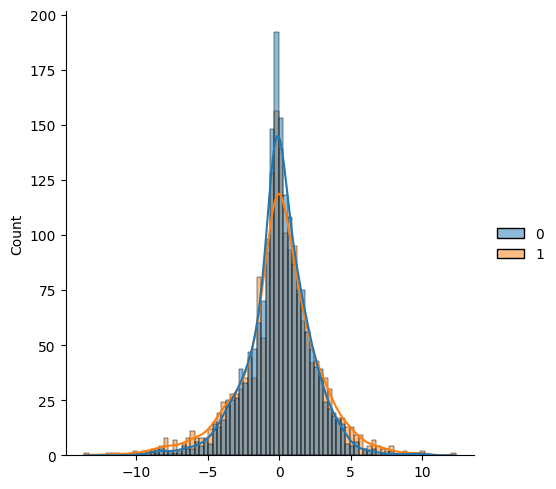

In [6]:
sbs.displot([seattle_max_diff, slc_max_diff], kde=True)
#sbs.displot(slc_max_diff, kde=True)

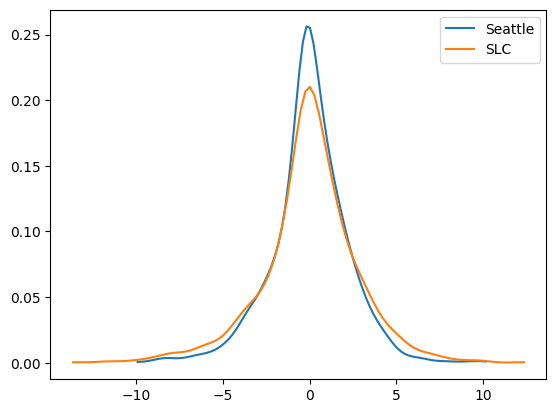

In [7]:
import scipy as sp

Xsea = np.mgrid[seattle_max_diff.min():seattle_max_diff.max():100j]
Xslc = np.mgrid[slc_max_diff.min():slc_max_diff.max():100j]
positions_sea = np.vstack([Xsea.ravel()])
positions_SLC = np.vstack([Xslc.ravel()])

sea_kernel = sp.stats.gaussian_kde(seattle_max_diff)
slc_kernel = sp.stats.gaussian_kde(slc_max_diff)
sea_kde = sea_kernel(positions_sea)
slc_kde = slc_kernel(positions_SLC)

plt.plot(Xsea, sea_kde, label='Seattle')
plt.plot(Xslc, slc_kde, label='SLC')
plt.legend()

In [8]:
sea_norm_cdf = np.cumsum(sea_kde) / np.sum(sea_kde)
slc_norm_cdf = np.cumsum(slc_kde) / np.sum(slc_kde)

sea_kde_df = 0.5 * np.diff(sea_kde) / np.diff(Xsea)
slc_kde_df = 0.5 * np.diff(slc_kde) / np.diff(Xslc)

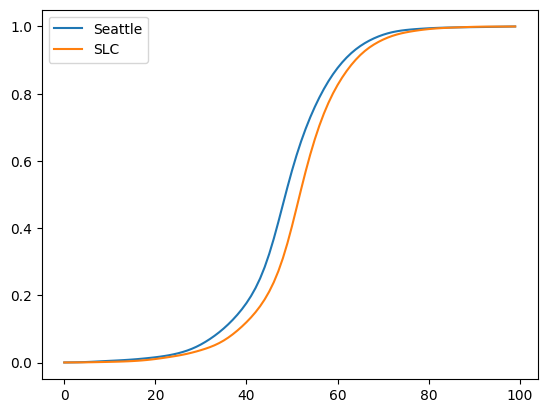

In [9]:
plt.plot(list(range(len(slc_norm_cdf))), sea_norm_cdf, label='Seattle')
plt.plot(list(range(len(slc_norm_cdf))), slc_norm_cdf, label='SLC')
plt.legend()


In [10]:
sea_min_idx, sea_max_idx = np.argwhere(sea_norm_cdf < .1)[-1][0], np.argwhere(sea_norm_cdf > .9)[0][0]
slc_min_idx, slc_max_idx = np.argwhere(slc_norm_cdf < .1)[-1][0], np.argwhere(slc_norm_cdf > .9)[0][0]
sea_mid1_idx, sea_mid2_idx = np.argwhere(sea_norm_cdf < .4)[-1][0], np.argwhere(sea_norm_cdf > .6)[0][0]
slc_mid1_idx, slc_mid2_idx = np.argwhere(slc_norm_cdf < .4)[-1][0], np.argwhere(slc_norm_cdf > .6)[0][0]

sea_min_bin = Xsea[sea_min_idx]
sea_max_bin = Xsea[sea_max_idx]
sea_min_dtemp = sea_kde[sea_min_idx]
sea_max_dtemp = sea_kde[sea_max_idx]

print(np.sum(sea_kde[:sea_min_idx] * Xsea[:sea_min_idx]), np.sum(sea_kde[sea_max_idx:] * Xsea[sea_max_idx:]))

slc_min_bin = Xsea[slc_min_idx]
slc_max_bin = Xsea[slc_max_idx]
slc_min_dtemp = slc_kde[slc_min_idx]
slc_max_dtemp = slc_kde[slc_max_idx]

print(np.sum(slc_kde[:slc_min_idx] * Xslc[:slc_min_idx]), np.sum(slc_kde[slc_max_idx:] * Xslc[slc_max_idx:]))

-1.836316173584775 2.0288426132829116
-1.8830173385618354 2.0549129624555453


In [11]:
from scipy import integrate as intgr

print(intgr.simpson(sea_kde[:sea_min_idx], Xsea[:sea_min_idx]), intgr.simpson(sea_kde[sea_max_idx:], Xsea[sea_max_idx:]))
print(intgr.simpson(slc_kde[:slc_min_idx], Xslc[:slc_min_idx]), intgr.simpson(slc_kde[slc_max_idx:], Xslc[slc_max_idx:]))
print(intgr.simpson(sea_kde[sea_mid1_idx:sea_mid2_idx], Xsea[sea_mid1_idx:sea_mid2_idx]), intgr.simpson(slc_kde[slc_mid1_idx:slc_mid2_idx], Xslc[slc_mid1_idx:slc_mid2_idx]))

0.07470244622573176 0.09944678295190539
0.07889621506242012 0.10649424197531154
0.20123011253997147 0.20992379158707203


In [12]:
print(np.trapz(sea_kde[:sea_min_idx], Xsea[:sea_min_idx]), np.trapz(sea_kde[sea_max_idx:], Xsea[sea_max_idx:]))
print(np.trapz(slc_kde[:slc_min_idx], Xslc[:slc_min_idx]), np.trapz(slc_kde[slc_max_idx:], Xslc[slc_max_idx:]))
print(np.trapz(sea_kde[sea_mid1_idx:sea_mid2_idx], Xsea[sea_mid1_idx:sea_mid2_idx]), np.trapz(slc_kde[slc_mid1_idx:slc_mid2_idx], Xslc[slc_mid1_idx:slc_mid2_idx]))

0.0747685115860667 0.09958690224601885
0.07899348676361032 0.10665336713353753
0.20050355444591403 0.20915644835058794


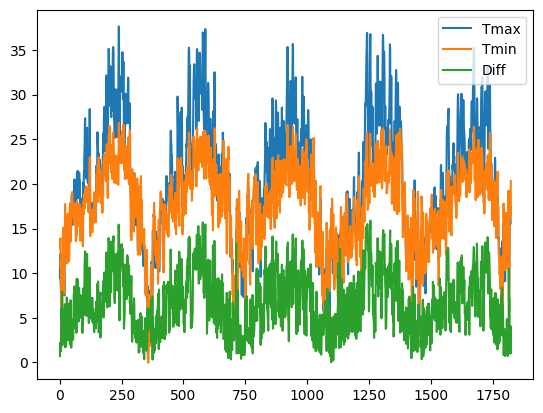

In [13]:
tmax = rootgrp.variables['tasmaxAdjust'][:][:, seattle_idx['lat'], seattle_idx['lon']] 
tmin = rootgrp.variables['tasminAdjust'][:][:, seattle_idx['lat'], seattle_idx['lon']]
tdiff = tmax - tmin

plt.plot(tmax - np.nanmin(tmax), label='Tmax')
plt.plot(tmin - np.nanmin(tmin), label='Tmin')
plt.plot(tdiff, label='Diff')
plt.legend()

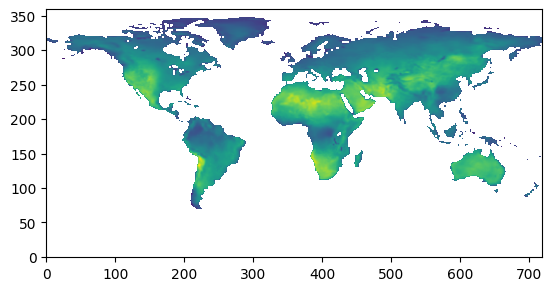

In [14]:
global_tmax = np.nanmean(rootgrp.variables['tasmaxAdjust'][:], axis=0)
global_tmin = np.nanmean(rootgrp.variables['tasminAdjust'][:], axis=0)
global_tdiff = global_tmax - global_tmin

plt.imshow(global_tdiff)
plt.gca().invert_yaxis()

In [ ]:
import timeit
# simpson should give a better answer and minimal computational increase

def simps():
    t0 = sea_kde[:sea_min_idx]
    t1 = Xsea[:sea_min_idx]
    return intgr.simpson(t0, t1)

def trapz():
    t0 = sea_kde[:sea_min_idx]
    t1 = Xsea[:sea_min_idx]
    return np.trapz(t0, t1)

t_simp = timeit.Timer(simps).repeat(10)
t_trapz = timeit.Timer(trapz).repeat(10)

print(t_simp, t_trapz, min(t_simp), min(t_trapz))
# turns out it's a substantial computational increase (~5x). Use trapz instead